# 1. Natural Language Processing
Natural Language Processing step to analyze the comments left on e-commerce orders. The goal is to use this as input to a sentimental analysis model for understanding the customer's sentiment on purchasing things online. Let's take a look on the reviews data.


In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#data cleaning
import re
import emoji
import string
%matplotlib inline


In [3]:
DATA_PATH = "../data_set/ecommerce_review/data.csv"

In [18]:
df_review = pd.read_csv(DATA_PATH)

## 1.1 Data Understanding

In [19]:
df_review.describe()

,start
count,31460.000000
mean,3.736840
std,1.382483
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [20]:
df_review.head()

,content,label,start
0,Áo bao đẹp ạ!,POS,5
1,Tuyệt vời,POS,5
2,2day ao khong giong trong,NEG,1
3,"Mùi thơm,bôi lên da mềm da",POS,5
4,"Vải đẹp, dày dặn",POS,5


So we have 31k reviews with label as "POS" for positive and "NEG" for negative. And start column represents the score user give for product.
Let's see the distribution of label and start.

([<matplotlib.patches.Wedge at 0x17dff1990>,
 [Text(1.0323996277547125, 0.3796722384003484, '1'),
  Text(0.5772283636050005, 0.9363799529303762, '2'),
  Text(-0.25107186570127626, 1.0709635466500624, '3'),
  Text(-1.079864344096105, 0.20950655920493041, '4'),
  Text(0.26580607364266073, -1.0674020475971895, '5')],
 [Text(0.5631270696843886, 0.20709394821837185, '11.22%'),
  Text(0.31485183469363665, 0.5107527015983869, '9.98%'),
  Text(-0.13694829038251433, 0.5841619345363976, '14.93%'),
  Text(-0.5890169149615118, 0.11427630502087112, '21.64%'),
  Text(0.14498513107781494, -0.5822192986893759, '42.23%')])

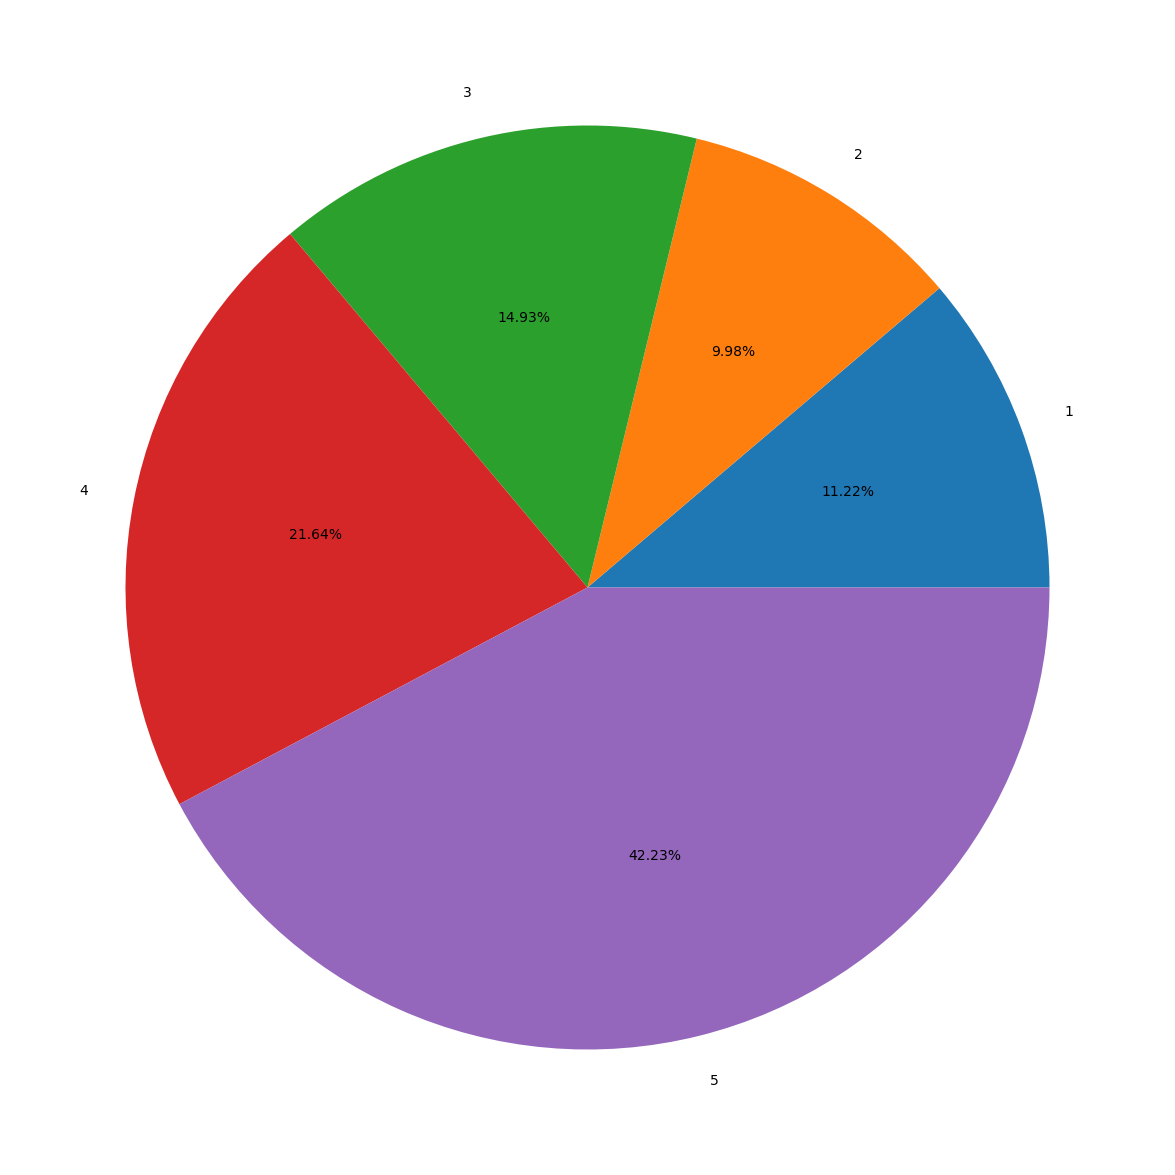

In [45]:
data_label = df_review['start']
data_label = pd.DataFrame(data_label, columns=['start']).groupby('start').size()
plt.figure(figsize=(15, 15))
plt.pie(data_label, autopct="%.2f%%", labels=data_label.index)


The data can be used for building sentimental analysis model. However, before that, we have to do some text preparation to transform the comments input into a vectors which can be used for machine learning modeling.

## 1.2 Data Cleaning using regex (regular expression)

### 1.2.1 clean breakline, hyperlink, date, number, etc...

In [92]:
'''
 For removing breakline
'''
def re_breakline(text):
    return re.sub('[\n\r]', ' ',text)

In [93]:
'''
 For removing punctuation, and space.
'''
def re_punctuation(text):
    return  " ".join(re.sub(f"[{re.escape(string.punctuation)}]", " ", str(text).lower()).split())

In [94]:
'''
 For removing number.
'''
def re_numbers(text):
    """
    Args:
    ----------
    texts: text content to be prepared [type: string]
    """
    # Applying regex
    return re.sub('[0-9]+', ' numero ', strtext) 

In [95]:
def re_hiperlinks(text):
    """
    Args:
    ----------
    texts: text content to be prepared [type: string]
    """
    # Applying regex
    pattern = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return re.sub(pattern, ' link ', text)

In [96]:
def re_emoiji(text):
    """
    Args:
    ----------
    texts: list object with text content to be prepared [type: list]
    """
    # Applying regex
    return emoji.replace_emoji(text)

In [101]:
def preprocess(text):
    text = re_numbers(text)
    text = re_emoiji(text)
    text = re_breakline(text)
    text = re_punctuation(text)
    text = re_hiperlinks(text)
    return text


In [102]:
df_review['cleaned_comment'] = df_review['content'].apply(preprocess)
df_review['cleaned_comment']

TypeError: expected string or bytes-like object, got 'float'